<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/vito/STEP_3B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [26]:
!pip install torchmetrics
!pip install fvcore

In [27]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

fatal: destination path 'AML_2025_project4' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [29]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Skipping extraction for the dataset, already extracted.
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [30]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

P = 0.5 # probabilità augmentation

# Define and instantiate

### Define PIDnet

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

# Dataset & dataloader

## Dataset definition

In [33]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])


        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        #return image, mask, boundaries_tensor  # Return (image, mask) pair
        return image, mask, boundaries_tensor  # Return (image, mask) pair

## Define transformations
(using albumentations)

In [34]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2
import itertools


resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

alb_aug0 = A.HorizontalFlip(p=P)
alb_aug1 = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))
alb_aug2 = A.ElasticTransform(alpha=1300, sigma=20, p=P)
alb_aug3 = A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=P
)
alb_aug4 = A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=P)
alb_aug5 = A.Spatter(
    mode="mud",
    mean=(0.55, 0.55),
    std=(0.25, 0.25),
    cutout_threshold=(0.7, 0.7),
    intensity=(0.6, 0.6),
    color=(120, 40, 40),  # Reddish-brown mud
    p=P
)


# Selezione delle 6 combinazioni specifiche
augmentations = [
    A.Compose([alb_aug0]),  # Solo orizzontale flip
    A.Compose([alb_aug1]),  # Solo gaussian blur
    A.Compose([alb_aug2]),  # Solo elastic transform
    A.Compose([alb_aug3]),  # Solo hue, saturation, value
    A.Compose([alb_aug4]),  # Solo color jitter
    A.Compose([alb_aug5]),  # Solo spatter
    A.Compose([alb_aug0, alb_aug1]),  # Flip + Gaussian blur
    A.Compose([alb_aug2, alb_aug3])   # Elastic transform + Hue, saturation, value
]

## Dataset instantiation

In [35]:
# Create dataset objects
DOMAIN_SHIFT = True

train_datasets = []

for i, augmentation in enumerate(augmentations):

  train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=resize_transform, augmentation=augmentation)
  train_datasets.append(train_dataset)

if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## Loader instantiation

In [36]:
# Create DataLoaders
train_loaders = []

for dataset in train_datasets:
  train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  train_loaders.append(train_loader)


train_loader = train_loaders[2] # provo con dataloader modifica saturation hue
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

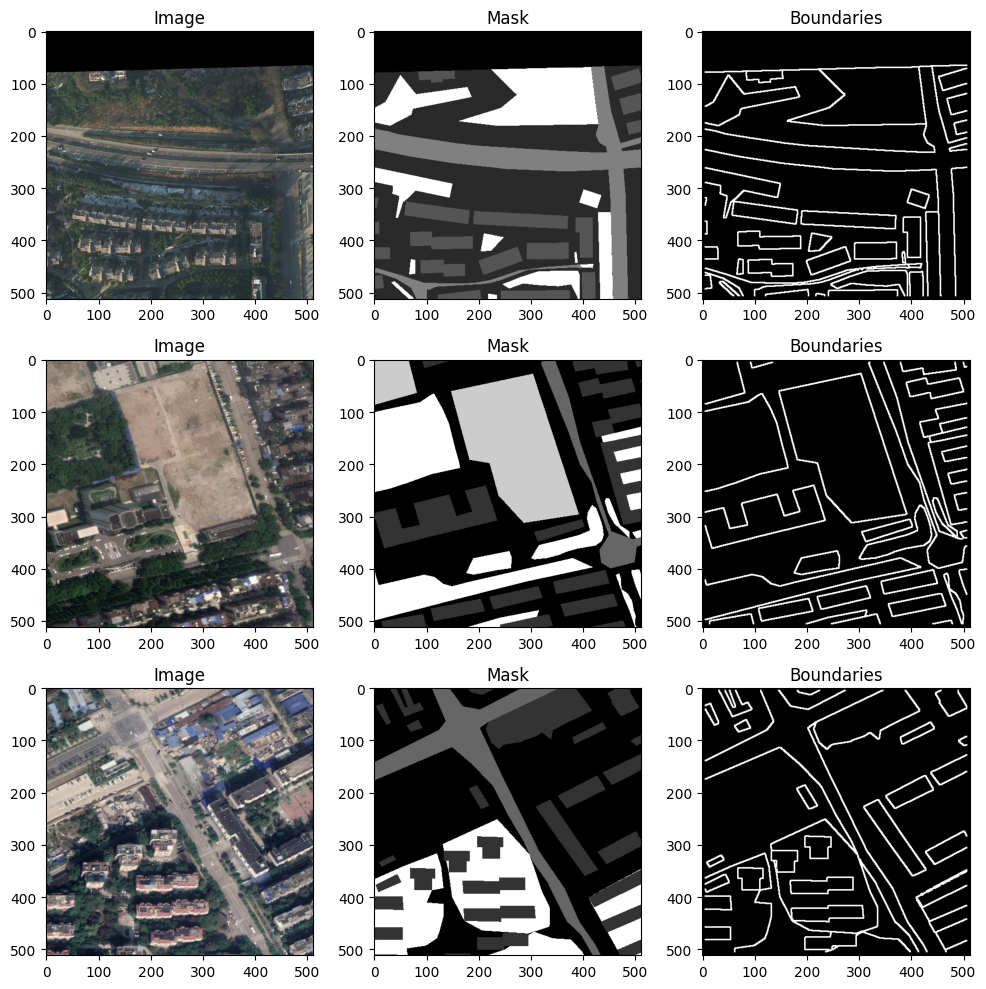

In [37]:
from utils import show
from matplotlib import pyplot as plt

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images

    # Permute the dimensions of the image tensor to (height, width, channels)
    image_np = images[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")


plt.tight_layout()
plt.show()

### Instantiate model

In [38]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device

# Instanzia n modelli (uno per ogni dataloader)
models = [get_seg_model(cfg, imgnet_pretrained=True) for _ in train_loaders]

# Training Phase

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

# 2. Weighted Binary Cross Entropy per i bordi
class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, pos_weight=20.0):  # Peso λ1 sui bordi
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    def forward(self, pred, target):
        return self.loss(pred, target)

# 3. Boundary-Aware CrossEntropy Loss
class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        ce_loss = self.loss(pred, target)
        return torch.mean(ce_loss * boundary_mask)  # Pesa i bordi

# 4. BAS-Loss per segmentazione e detection dei bordi
class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera bordi
        log_probs = F.log_softmax(pred, dim=1)

        # Reshape per compatibilità
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Applica la perdita solo ai bordi
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        # Normalizza rispetto al numero di pixel nei bordi (evita divisioni per 0)
        return loss / (boundary_mask.sum() + 1e-6)

# 5. PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.wbce_loss = WeightedBinaryCrossEntropy(pos_weight=lambda_1)
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        """
        pred: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """
        L0 = self.ce_loss(pred, target)  # Extra Semantic Loss
        L1 = self.wbce_loss(boundary_head, boundary_mask.unsqueeze(1))  # Weighted BCE
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)  # Boundary-Aware CE
        L3 = self.bas_loss(boundary_head, pred, target)  # BAS-Loss

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [42]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU


def file_exists(modelID):
    #path = f"/content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_{modelID}.pth"
    path = f"/content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_{modelID}.pth"
    return os.path.exists(path)


#os.makedirs("/content/drive/MyDrive/AML_project/checkpoints_new", exist_ok=True)
os.makedirs("/content/drive/MyDrive/AML_project/checkpoints_1205", exist_ok=True)

torch.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset

miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

k = 0
miou_results = []
model_train_loader = zip(models, train_loaders)
for model, train_loader in model_train_loader:

  optimizer = torch.optim.SGD(model.parameters(), lr=LR)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

  print(f"📊 Processig the model with ID: {k}")
  model.to(device)
  loss_fn = PIDNetLoss()

  if file_exists(k):
    print(f"⚠️ The model with ID: {k}, already exist, skipped!")
    k = k + 1
    continue

  for epoch in range(EPOCHS):
      model.train()
      train_loss = 0

      total_train_samples = 0

      batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

      for batch, (X, y, boundary_mask) in batch_pbar:
          X = X.to(device)
          y = y.to(device)
          boundary_mask = boundary_mask.to(device)

          # Output del modello
          outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

          # Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
          # Quindi passiamo da 64 x 64 della rete a 512 x 512
          h, w = boundary_mask.size(1), boundary_mask.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          if model.augment:
              pred_p, pred_main, boundary_head = outputs  # P, I, D branches
          else:
              pred_main = outputs
              boundary_head = None  # Nessuna branch D se augment=False

          # Calcolo della loss
          loss = loss_fn(pred_main, y, boundary_head, boundary_mask)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_train_samples += X.size(0)

          train_loss += loss.item()
          batch_pbar.set_postfix(loss=loss.item())

      #avg_train_loss = train_loss / len(train_loader)

      #total_samples = sum(len(batch[0]) for batch in train_loader)
      avg_train_loss = train_loss / total_train_samples


      print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")


      # **Validazione**
      model.eval()
      miou_classes.reset()
      val_loss = 0

      total_union = torch.zeros(NUM_CLASSES).to(device)
      total_intersection = torch.zeros(NUM_CLASSES).to(device)

      import torch.nn.functional as F

      total_val_samples = 0

      with torch.inference_mode():
          for X_val, y_val, boundary_mask in val_loader:
              X_val = X_val.to(device)
              y_val = y_val.to(device)
              boundary_mask = boundary_mask.to(device)

              # Output del modello
              outputs = model(X_val)

              ## Upscale trough bilinear interpolation
              h, w = boundary_mask.size(1), boundary_mask.size(2)
              ph, pw = outputs[0].size(2), outputs[0].size(3)
              if ph != h or pw != w:
                  for i in range(len(outputs)):
                      outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

              if model.augment:
                  pred_p, pred_main, boundary_head = outputs
              else:
                  pred_main = outputs
                  boundary_head = None

              # Calcola le predizioni
              preds = pred_main.argmax(dim=1)  # Shape: (N, H, W)

              # Mask dei pixel validi (classi da 0 a num_classes - 1)
              valid_mask = (y_val >= 0) & (y_val < num_classes)

              # Appiattisci le predizioni e i target solo sui pixel validi
              preds_flat = preds[valid_mask]
              targets_flat = y_val[valid_mask]

              miou_classes.update(preds_flat, targets_flat)

              # output_class_per_pixel = torch.argmax(outputs[1], dim=1)

              # for predicted, target in zip(output_class_per_pixel, y_val):
              #   for i in range(NUM_CLASSES):
              #     total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
              #     total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))


              # Calcola la loss
              loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

              val_loss += loss.item()

              total_val_samples += X_val.size(0)

      avg_val_loss = val_loss / total_val_samples

      # intersection_over_union = total_intersection / total_union
      # # per class
      # for i, iou in enumerate(intersection_over_union):
      #     class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
      #     print(f'{class_name} IoU: {iou:.4f}')

      # miou = torch.mean(intersection_over_union)

      miou_per_class = miou_classes.compute()
      miou = miou_per_class.mean()

      print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")

      if epoch % 5 == 0:
        print(scheduler.get_last_lr())

      ## steps the scheduler
      scheduler.step(miou)

  checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_{k}.pth"
  #checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_{k}.pth"
  torch.save(model.state_dict(), checkpoint_path)
  print(f"Modello salvato: {checkpoint_path}")

  # Crea dizionario dei risultati per questo modello
  model_miou_dict = {
      "model_id": k,
      "miou_per_class": {
          miou_per_class
      },
      "miou_overall": float(miou)
  }

  # Aggiungilo alla lista dei risultati
  miou_results.append(model_miou_dict)
  k = k  + 1

📊 Processig the model with ID: 0


Epoch 1/20: 100%|██████████████████████████████████████████| 73/73 [00:19<00:00,  3.83it/s, loss=38]

Epoch 1/20 - Training Loss: 1.9775412354914788


Epoch 1/20 - Validation Loss: 1.5957763579583937 - mIoU: 0.12333022058010101
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.85it/s, loss=32.1]

Epoch 2/20 - Training Loss: 1.952324439910044


Epoch 2/20 - Validation Loss: 1.5812551936795634 - mIoU: 0.13217927515506744


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.87it/s, loss=31.9]

Epoch 3/20 - Training Loss: 1.9115826118363641


Epoch 3/20 - Validation Loss: 1.5528664165927517 - mIoU: 0.14743435382843018


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.86it/s, loss=38.3]

Epoch 4/20 - Training Loss: 1.903707621419306


Epoch 4/20 - Validation Loss: 1.5430265261280922 - mIoU: 0.1668550819158554


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.85it/s, loss=29.6]

Epoch 5/20 - Training Loss: 1.8721474281231838


Epoch 5/20 - Validation Loss: 1.5415675294014715 - mIoU: 0.16112571954727173


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.84it/s, loss=32.4]

Epoch 6/20 - Training Loss: 1.8620041678933537


Epoch 6/20 - Validation Loss: 1.5211519387460524 - mIoU: 0.19153176248073578
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.87it/s, loss=26.8]

Epoch 7/20 - Training Loss: 1.8499477957359234


Epoch 7/20 - Validation Loss: 1.5458805003473837 - mIoU: 0.18516847491264343


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.83it/s, loss=26.3]

Epoch 8/20 - Training Loss: 1.83498615212094


Epoch 8/20 - Validation Loss: 1.71793754254618 - mIoU: 0.1968938708305359


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:18<00:00,  3.87it/s, loss=45.1]

Epoch 9/20 - Training Loss: 1.8382111272184907


Epoch 9/20 - Validation Loss: 1.9315404930422384 - mIoU: 0.11782670021057129


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.84it/s, loss=35.5]

Epoch 10/20 - Training Loss: 1.8334086560048033


Epoch 10/20 - Validation Loss: 1.5485614288237788 - mIoU: 0.22360879182815552


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.82it/s, loss=29.6]

Epoch 11/20 - Training Loss: 1.8056112721717068


Epoch 11/20 - Validation Loss: 1.586301403660928 - mIoU: 0.22335144877433777
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.78it/s, loss=33.1]

Epoch 12/20 - Training Loss: 1.7889906592847566


Epoch 12/20 - Validation Loss: 1.5682982802391052 - mIoU: 0.22180521488189697


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.79it/s, loss=31.8]

Epoch 13/20 - Training Loss: 1.7843638522402225


Epoch 13/20 - Validation Loss: 1.569519454433072 - mIoU: 0.21398626267910004


Epoch 14/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.79it/s, loss=23]

Epoch 14/20 - Training Loss: 1.762255181903245


Epoch 14/20 - Validation Loss: 1.7261074493008275 - mIoU: 0.2196526974439621


Epoch 15/20: 100%|█████████████████████████████████████████| 73/73 [00:19<00:00,  3.81it/s, loss=25]

Epoch 15/20 - Training Loss: 1.7383079792801484


Epoch 15/20 - Validation Loss: 1.67026287317276 - mIoU: 0.22093740105628967


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:18<00:00,  3.85it/s, loss=37.8]

Epoch 16/20 - Training Loss: 1.7385182991159829


Epoch 16/20 - Validation Loss: 1.6627161060610125 - mIoU: 0.23808342218399048
[0.001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.82it/s, loss=21.9]

Epoch 17/20 - Training Loss: 1.7257853857786185


Epoch 17/20 - Validation Loss: 1.6868425396180922 - mIoU: 0.23683583736419678


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.80it/s, loss=26.7]

Epoch 18/20 - Training Loss: 1.7221015596884757


Epoch 18/20 - Validation Loss: 1.7837114622516017 - mIoU: 0.23390266299247742


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.78it/s, loss=32.1]

Epoch 19/20 - Training Loss: 1.7289012410648967


Epoch 19/20 - Validation Loss: 1.7673353745091347 - mIoU: 0.2399635910987854


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:19<00:00,  3.84it/s, loss=28.6]

Epoch 20/20 - Training Loss: 1.7239270226765668


Epoch 20/20 - Validation Loss: 1.8578254522815827 - mIoU: 0.22671949863433838
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_0.pth
📊 Processig the model with ID: 1


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=34.4]

Epoch 1/20 - Training Loss: 2.4133265043212466


Epoch 1/20 - Validation Loss: 1.6678269524728098 - mIoU: 0.10573326796293259
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=34.2]

Epoch 2/20 - Training Loss: 1.9867280148304869


Epoch 2/20 - Validation Loss: 1.6156872664728472 - mIoU: 0.125409796833992


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=32.4]

Epoch 3/20 - Training Loss: 1.9349936762483062


Epoch 3/20 - Validation Loss: 1.5671556938079096 - mIoU: 0.15880925953388214


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=34.7]

Epoch 4/20 - Training Loss: 1.9097717262056872


Epoch 4/20 - Validation Loss: 1.5757064415562538 - mIoU: 0.15505310893058777


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=38.4]

Epoch 5/20 - Training Loss: 1.8918533242697535


Epoch 5/20 - Validation Loss: 1.5846474497548995 - mIoU: 0.14765912294387817


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=26.8]

Epoch 6/20 - Training Loss: 1.8579964720254125


Epoch 6/20 - Validation Loss: 1.5887163454486477 - mIoU: 0.17287760972976685
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=27.3]

Epoch 7/20 - Training Loss: 1.8409067305726576


Epoch 7/20 - Validation Loss: 1.577774740034534 - mIoU: 0.18587861955165863


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=24.9]

Epoch 8/20 - Training Loss: 1.8293935237871322


Epoch 8/20 - Validation Loss: 1.5972046640611464 - mIoU: 0.18585076928138733


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=36.6]

Epoch 9/20 - Training Loss: 1.816067471223719


Epoch 9/20 - Validation Loss: 1.7192617577891196 - mIoU: 0.16229671239852905


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=31.8]

Epoch 10/20 - Training Loss: 1.793859892650459


Epoch 10/20 - Validation Loss: 1.6096274852752686 - mIoU: 0.19489052891731262


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=37.3]

Epoch 11/20 - Training Loss: 1.7839522939239818


Epoch 11/20 - Validation Loss: 1.9248359299475146 - mIoU: 0.14989805221557617
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.63it/s, loss=30.1]

Epoch 12/20 - Training Loss: 1.7762792877672453


Epoch 12/20 - Validation Loss: 1.6332286538616303 - mIoU: 0.1987275779247284


Epoch 13/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=22]

Epoch 13/20 - Training Loss: 1.7369724227482886


Epoch 13/20 - Validation Loss: 2.1975744578146164 - mIoU: 0.20028993487358093


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=27.1]

Epoch 14/20 - Training Loss: 1.717757513778845


Epoch 14/20 - Validation Loss: 1.8497788925324716 - mIoU: 0.20383022725582123


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=31.5]

Epoch 15/20 - Training Loss: 1.7161050733810477


Epoch 15/20 - Validation Loss: 1.8789835418424299 - mIoU: 0.2002222090959549


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=23.4]

Epoch 16/20 - Training Loss: 1.6896890471963322


Epoch 16/20 - Validation Loss: 1.6904894171222564 - mIoU: 0.21375755965709686
[0.01]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.63it/s, loss=19.6]

Epoch 17/20 - Training Loss: 1.663402648120603


Epoch 17/20 - Validation Loss: 1.7128880081638214 - mIoU: 0.21189765632152557


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=22.9]

Epoch 18/20 - Training Loss: 1.6544395631572366


Epoch 18/20 - Validation Loss: 2.0563722925801433 - mIoU: 0.19963614642620087


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=25.4]

Epoch 19/20 - Training Loss: 1.6310335558591005


Epoch 19/20 - Validation Loss: 2.276302662587935 - mIoU: 0.20231467485427856


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=32.2]

Epoch 20/20 - Training Loss: 1.6316614761484536


Epoch 20/20 - Validation Loss: 1.84162877644262 - mIoU: 0.2032526284456253
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_1.pth
📊 Processig the model with ID: 2


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:46<00:00,  1.57it/s, loss=31.5]

Epoch 1/20 - Training Loss: 2.3849892154284413


Epoch 1/20 - Validation Loss: 1.676371572479125 - mIoU: 0.12764626741409302
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:46<00:00,  1.57it/s, loss=33.7]

Epoch 2/20 - Training Loss: 2.000419926890865


Epoch 2/20 - Validation Loss: 1.5777917292810255 - mIoU: 0.1450231969356537


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:46<00:00,  1.56it/s, loss=30.5]

Epoch 3/20 - Training Loss: 1.9621933273790617


Epoch 3/20 - Validation Loss: 1.671645095271449 - mIoU: 0.15500476956367493


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:46<00:00,  1.56it/s, loss=42.4]

Epoch 4/20 - Training Loss: 1.9376973115861622


Epoch 4/20 - Validation Loss: 24.201511521493234 - mIoU: 0.05763642489910126


Epoch 5/20: 100%|██████████████████████████████████████████| 73/73 [00:47<00:00,  1.54it/s, loss=25]

Epoch 5/20 - Training Loss: 1.9187372597031114


Epoch 5/20 - Validation Loss: 1.5405014791796285 - mIoU: 0.16338858008384705


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:47<00:00,  1.53it/s, loss=32.2]

Epoch 6/20 - Training Loss: 1.894384590399719


Epoch 6/20 - Validation Loss: 1.5444033934224037 - mIoU: 0.1918981671333313
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s, loss=29.5]

Epoch 7/20 - Training Loss: 1.8782813441794637


Epoch 7/20 - Validation Loss: 1.662434374132464 - mIoU: 0.19208186864852905


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:47<00:00,  1.54it/s, loss=24.6]

Epoch 8/20 - Training Loss: 1.8535126831292281


Epoch 8/20 - Validation Loss: 1.6651449799537659 - mIoU: 0.18008758127689362


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s, loss=28.2]

Epoch 9/20 - Training Loss: 1.848148545591889


Epoch 9/20 - Validation Loss: 1.548646588479319 - mIoU: 0.16801129281520844


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s, loss=22.6]

Epoch 10/20 - Training Loss: 1.8335839720333325


Epoch 10/20 - Validation Loss: 1.7118569304866176 - mIoU: 0.18780003488063812


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.54it/s, loss=28.4]

Epoch 11/20 - Training Loss: 1.8120302824000587


Epoch 11/20 - Validation Loss: 1.6380817813258017 - mIoU: 0.21214531362056732
[0.001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.52it/s, loss=27.9]

Epoch 12/20 - Training Loss: 1.8027115940635179


Epoch 12/20 - Validation Loss: 1.5786997099076547 - mIoU: 0.20784638822078705


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.54it/s, loss=33.6]

Epoch 13/20 - Training Loss: 1.802706177259399


Epoch 13/20 - Validation Loss: 1.620990749328367 - mIoU: 0.2129868119955063


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=25.2]

Epoch 14/20 - Training Loss: 1.7954839224633874


Epoch 14/20 - Validation Loss: 1.6422259653768232 - mIoU: 0.21692399680614471


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.54it/s, loss=31.1]

Epoch 15/20 - Training Loss: 1.7951547975771156


Epoch 15/20 - Validation Loss: 1.6514832223615339 - mIoU: 0.21322371065616608


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:46<00:00,  1.56it/s, loss=35.1]

Epoch 16/20 - Training Loss: 1.7915954226853525


Epoch 16/20 - Validation Loss: 1.6429660185690849 - mIoU: 0.2226133793592453
[0.001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.53it/s, loss=27.8]

Epoch 17/20 - Training Loss: 1.7964414626256817


Epoch 17/20 - Validation Loss: 1.6023040375401896 - mIoU: 0.21580751240253448


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s, loss=24.6]

Epoch 18/20 - Training Loss: 1.7821385175711555


Epoch 18/20 - Validation Loss: 1.6285316309621256 - mIoU: 0.21471790969371796


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s, loss=29.4]

Epoch 19/20 - Training Loss: 1.784206626324505


Epoch 19/20 - Validation Loss: 1.611500645837476 - mIoU: 0.22126361727714539


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:46<00:00,  1.56it/s, loss=28.8]

Epoch 20/20 - Training Loss: 1.781558079703044


Epoch 20/20 - Validation Loss: 1.673211862964015 - mIoU: 0.21703213453292847
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_2.pth
📊 Processig the model with ID: 3


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=31.3]

Epoch 1/20 - Training Loss: 2.4290104654833518


Epoch 1/20 - Validation Loss: 1.6863138733371612 - mIoU: 0.14052236080169678
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=34.2]

Epoch 2/20 - Training Loss: 2.009139521311724


Epoch 2/20 - Validation Loss: 1.6324993737282292 - mIoU: 0.11547024548053741


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=39.2]

Epoch 3/20 - Training Loss: 1.9675874380091896


Epoch 3/20 - Validation Loss: 1.901776638723189 - mIoU: 0.13592474162578583


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=40.8]

Epoch 4/20 - Training Loss: 1.9453331689933593


Epoch 4/20 - Validation Loss: 1.8474454283714294 - mIoU: 0.12925615906715393


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=30.9]

Epoch 5/20 - Training Loss: 1.9212958540470955


Epoch 5/20 - Validation Loss: 1.5845366293384182 - mIoU: 0.14052775502204895


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=29.7]

Epoch 6/20 - Training Loss: 1.8920950840088735


Epoch 6/20 - Validation Loss: 1.5498306981978878 - mIoU: 0.14156675338745117
[0.001]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=26.8]

Epoch 7/20 - Training Loss: 1.882776250476243


Epoch 7/20 - Validation Loss: 1.5470143633504068 - mIoU: 0.15230214595794678


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=32.9]

Epoch 8/20 - Training Loss: 1.8811245954572948


Epoch 8/20 - Validation Loss: 1.546213190401754 - mIoU: 0.14309239387512207


Epoch 9/20: 100%|██████████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=36]

Epoch 9/20 - Training Loss: 1.8771159525148597


Epoch 9/20 - Validation Loss: 1.5489623546600342 - mIoU: 0.1442914754152298


Epoch 10/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=29]

Epoch 10/20 - Training Loss: 1.8714524767390583


Epoch 10/20 - Validation Loss: 1.5410379805872518 - mIoU: 0.152865931391716


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=27.4]

Epoch 11/20 - Training Loss: 1.8710334325744207


Epoch 11/20 - Validation Loss: 1.5481128750308868 - mIoU: 0.14444750547409058
[0.001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=35.9]

Epoch 12/20 - Training Loss: 1.873543612272269


Epoch 12/20 - Validation Loss: 1.5447282272000467 - mIoU: 0.15036386251449585


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=30.1]

Epoch 13/20 - Training Loss: 1.8688391352194815


Epoch 13/20 - Validation Loss: 1.5467716532368814 - mIoU: 0.14743585884571075


Epoch 14/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=29]

Epoch 14/20 - Training Loss: 1.8660832754880912


Epoch 14/20 - Validation Loss: 1.5465115462580035 - mIoU: 0.15042118728160858


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=29.6]

Epoch 15/20 - Training Loss: 1.872246841245869


Epoch 15/20 - Validation Loss: 1.5425416192700785 - mIoU: 0.15372830629348755


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=30.5]

Epoch 16/20 - Training Loss: 1.8699903768651627


Epoch 16/20 - Validation Loss: 1.543325952945217 - mIoU: 0.15034905076026917
[1e-05]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=38.4]

Epoch 17/20 - Training Loss: 1.8729315497058485


Epoch 17/20 - Validation Loss: 1.5431748840116686 - mIoU: 0.15191511809825897


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=24.3]

Epoch 18/20 - Training Loss: 1.8654459933508638


Epoch 18/20 - Validation Loss: 1.551501129904101 - mIoU: 0.14762215316295624


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=30.5]

Epoch 19/20 - Training Loss: 1.8688544682565444


Epoch 19/20 - Validation Loss: 1.5488977143841405 - mIoU: 0.14514386653900146


Epoch 20/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=35]

Epoch 20/20 - Training Loss: 1.868881382331716


Epoch 20/20 - Validation Loss: 1.5478416892790026 - mIoU: 0.15482187271118164
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_3.pth
📊 Processig the model with ID: 4


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.34it/s, loss=27.6]

Epoch 1/20 - Training Loss: 2.3350775547093585


Epoch 1/20 - Validation Loss: 1.6525281283163256 - mIoU: 0.12802980840206146
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=35.2]

Epoch 2/20 - Training Loss: 1.9921451505905203


Epoch 2/20 - Validation Loss: 1.6540068522576363 - mIoU: 0.14611950516700745


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.37it/s, loss=29.6]

Epoch 3/20 - Training Loss: 1.9380348644454586


Epoch 3/20 - Validation Loss: 1.5722650135717084 - mIoU: 0.15365910530090332


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=44.7]

Epoch 4/20 - Training Loss: 1.9225012290848993


Epoch 4/20 - Validation Loss: 1.583475612824963 - mIoU: 0.17316050827503204


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.37it/s, loss=23.1]

Epoch 5/20 - Training Loss: 1.8794685499065888


Epoch 5/20 - Validation Loss: 1.578178011601971 - mIoU: 0.21605584025382996


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.38it/s, loss=30.5]

Epoch 6/20 - Training Loss: 1.8680884978350472


Epoch 6/20 - Validation Loss: 1.5570882789550289 - mIoU: 0.2148989886045456
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.34it/s, loss=35.1]

Epoch 7/20 - Training Loss: 1.8498841289005477


Epoch 7/20 - Validation Loss: 1.5361898368404758 - mIoU: 0.22804026305675507


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=39.1]

Epoch 8/20 - Training Loss: 1.832989034355718


Epoch 8/20 - Validation Loss: 1.64880637391921 - mIoU: 0.2033999264240265


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:21<00:00,  3.36it/s, loss=35.7]

Epoch 9/20 - Training Loss: 1.8172207802637226


Epoch 9/20 - Validation Loss: 1.558562780580213 - mIoU: 0.23447181284427643


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.37it/s, loss=28.9]

Epoch 10/20 - Training Loss: 1.785417853754697


Epoch 10/20 - Validation Loss: 1.5604051563047594 - mIoU: 0.22303664684295654


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=27.6]

Epoch 11/20 - Training Loss: 1.7658828946545875


Epoch 11/20 - Validation Loss: 1.5985939868034855 - mIoU: 0.2260819375514984
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.36it/s, loss=35.3]

Epoch 12/20 - Training Loss: 1.7674373425414405


Epoch 12/20 - Validation Loss: 1.6402915062442902 - mIoU: 0.2573566436767578


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=29.8]

Epoch 13/20 - Training Loss: 1.7406493289247928


Epoch 13/20 - Validation Loss: 1.8348227989289068 - mIoU: 0.22332561016082764


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.33it/s, loss=34.2]

Epoch 14/20 - Training Loss: 1.722669172451983


Epoch 14/20 - Validation Loss: 2.2223981907290797 - mIoU: 0.22646012902259827


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.36it/s, loss=19.9]

Epoch 15/20 - Training Loss: 1.698139987602366


Epoch 15/20 - Validation Loss: 1.832039262017896 - mIoU: 0.23615232110023499


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=34.2]

Epoch 16/20 - Training Loss: 1.6918427671940681


Epoch 16/20 - Validation Loss: 2.0473864616886264 - mIoU: 0.2565186023712158
[0.01]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.35it/s, loss=30.5]

Epoch 17/20 - Training Loss: 1.676112455480239


Epoch 17/20 - Validation Loss: 1.7088066570220455 - mIoU: 0.26775896549224854


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.36it/s, loss=30.2]

Epoch 18/20 - Training Loss: 1.640337477093337


Epoch 18/20 - Validation Loss: 1.7046701869656962 - mIoU: 0.2637783885002136


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.32it/s, loss=29.8]

Epoch 19/20 - Training Loss: 1.6298787965081554


Epoch 19/20 - Validation Loss: 1.7227553609878785 - mIoU: 0.2687412202358246


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:21<00:00,  3.34it/s, loss=26.4]

Epoch 20/20 - Training Loss: 1.6199130368480221


Epoch 20/20 - Validation Loss: 1.7424190775040658 - mIoU: 0.2596644461154938
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_4.pth
📊 Processig the model with ID: 5


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:40<00:00,  1.81it/s, loss=33.3]

Epoch 1/20 - Training Loss: 2.3885508639589728


Epoch 1/20 - Validation Loss: 1.689494083004613 - mIoU: 0.09720601886510849
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=31.1]

Epoch 2/20 - Training Loss: 2.0155291161322677


Epoch 2/20 - Validation Loss: 1.6036259512747488 - mIoU: 0.12031332403421402


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=38.4]

Epoch 3/20 - Training Loss: 1.9716175666729885


Epoch 3/20 - Validation Loss: 1.9089388097486188 - mIoU: 0.12893229722976685


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.85it/s, loss=22.7]

Epoch 4/20 - Training Loss: 1.9161910449757296


Epoch 4/20 - Validation Loss: 1.717165393214072 - mIoU: 0.14026102423667908


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:40<00:00,  1.82it/s, loss=30.2]

Epoch 5/20 - Training Loss: 1.8944378130163702


Epoch 5/20 - Validation Loss: 1.5551254730070792 - mIoU: 0.15711313486099243


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:40<00:00,  1.82it/s, loss=28.8]


Epoch 6/20 - Training Loss: 1.8718933448659507
Epoch 6/20 - Validation Loss: 1.6411031907604587 - mIoU: 0.16706696152687073
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=26.8]

Epoch 7/20 - Training Loss: 1.8518757391140948


Epoch 7/20 - Validation Loss: 1.580130978938072 - mIoU: 0.15944764018058777


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=32.8]

Epoch 8/20 - Training Loss: 1.8464621507585255


Epoch 8/20 - Validation Loss: 1.6687234370939192 - mIoU: 0.16114841401576996


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=28.7]

Epoch 9/20 - Training Loss: 1.8188899809101462


Epoch 9/20 - Validation Loss: 1.5571852134120079 - mIoU: 0.20279046893119812


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=27.1]

Epoch 10/20 - Training Loss: 1.8035370717824124


Epoch 10/20 - Validation Loss: 1.6642838024323987 - mIoU: 0.1849430650472641


Epoch 11/20: 100%|█████████████████████████████████████████| 73/73 [00:39<00:00,  1.83it/s, loss=28]

Epoch 11/20 - Training Loss: 1.8012304702019608


Epoch 11/20 - Validation Loss: 1.6358815835368248 - mIoU: 0.19671174883842468
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.85it/s, loss=27.3]

Epoch 12/20 - Training Loss: 1.7772000108210686


Epoch 12/20 - Validation Loss: 1.876773476600647 - mIoU: 0.21235963702201843


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.85it/s, loss=26.4]

Epoch 13/20 - Training Loss: 1.7601569185619947


Epoch 13/20 - Validation Loss: 1.8271756422135137 - mIoU: 0.19838102161884308


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:38<00:00,  1.88it/s, loss=24.1]

Epoch 14/20 - Training Loss: 1.740152882044703


Epoch 14/20 - Validation Loss: 1.7035569221742692 - mIoU: 0.22139868140220642


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.86it/s, loss=29.5]

Epoch 15/20 - Training Loss: 1.7277707195611973


Epoch 15/20 - Validation Loss: 1.9985606497333896 - mIoU: 0.20432434976100922


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.86it/s, loss=27.5]

Epoch 16/20 - Training Loss: 1.7002315950228681


Epoch 16/20 - Validation Loss: 1.7869395440624607 - mIoU: 0.24178235232830048
[0.01]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:38<00:00,  1.88it/s, loss=20.7]

Epoch 17/20 - Training Loss: 1.6812507569996131


Epoch 17/20 - Validation Loss: 2.0855417020859255 - mIoU: 0.21472865343093872


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.86it/s, loss=24.3]

Epoch 18/20 - Training Loss: 1.6729521767903364


Epoch 18/20 - Validation Loss: 1.8179035071403749 - mIoU: 0.20151230692863464


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:39<00:00,  1.86it/s, loss=31.9]

Epoch 19/20 - Training Loss: 1.662751196164986


Epoch 19/20 - Validation Loss: 2.0419493163785627 - mIoU: 0.20854051411151886


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:38<00:00,  1.87it/s, loss=33.7]

Epoch 20/20 - Training Loss: 1.6455475615795097


Epoch 20/20 - Validation Loss: 2.541797637939453 - mIoU: 0.17495150864124298
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_5.pth
📊 Processig the model with ID: 6


Epoch 1/20: 100%|██████████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=29]

Epoch 1/20 - Training Loss: 2.3338231264926157


Epoch 1/20 - Validation Loss: 1.700344939385691 - mIoU: 0.09544232487678528
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=26.9]

Epoch 2/20 - Training Loss: 2.0036956645213198


Epoch 2/20 - Validation Loss: 1.6141439118692953 - mIoU: 0.13417431712150574


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=42.7]

Epoch 3/20 - Training Loss: 1.959500751693356


Epoch 3/20 - Validation Loss: 1.759671195860832 - mIoU: 0.1335548460483551


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=27.1]

Epoch 4/20 - Training Loss: 1.923421821792233


Epoch 4/20 - Validation Loss: 1.6100791462006108 - mIoU: 0.144673690199852


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=31.8]

Epoch 5/20 - Training Loss: 1.9007617264057939


Epoch 5/20 - Validation Loss: 1.584065512303383 - mIoU: 0.15058135986328125


Epoch 6/20: 100%|██████████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=36]

Epoch 6/20 - Training Loss: 1.8862347173855791


Epoch 6/20 - Validation Loss: 1.6060915397059532 - mIoU: 0.18166573345661163
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=38.3]

Epoch 7/20 - Training Loss: 1.876651773815749


Epoch 7/20 - Validation Loss: 1.614994921991902 - mIoU: 0.2093883454799652


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=27.2]

Epoch 8/20 - Training Loss: 1.8508980447445773


Epoch 8/20 - Validation Loss: 1.6369459494467704 - mIoU: 0.19024959206581116


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=21.6]

Epoch 9/20 - Training Loss: 1.8375348780806915


Epoch 9/20 - Validation Loss: 1.623922461463559 - mIoU: 0.21294255554676056


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=36.5]

Epoch 10/20 - Training Loss: 1.832459194024954


Epoch 10/20 - Validation Loss: 1.7520296016047079 - mIoU: 0.17828468978405


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=26.6]

Epoch 11/20 - Training Loss: 1.8192989883950836


Epoch 11/20 - Validation Loss: 1.693689542431985 - mIoU: 0.21551360189914703
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=30.6]

Epoch 12/20 - Training Loss: 1.804098781004909


Epoch 12/20 - Validation Loss: 1.5753274656111194 - mIoU: 0.23626704514026642


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.48it/s, loss=35.9]

Epoch 13/20 - Training Loss: 1.7952157997342542


Epoch 13/20 - Validation Loss: 1.7619257338585392 - mIoU: 0.2183910608291626


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.49it/s, loss=35.4]

Epoch 14/20 - Training Loss: 1.7921999878536872


Epoch 14/20 - Validation Loss: 1.7595977783203125 - mIoU: 0.2118830382823944


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=28.7]

Epoch 15/20 - Training Loss: 1.7804567987118625


Epoch 15/20 - Validation Loss: 1.5868947294450575 - mIoU: 0.21903257071971893


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=22.1]

Epoch 16/20 - Training Loss: 1.7648661606864533


Epoch 16/20 - Validation Loss: 2.237785162464265 - mIoU: 0.22074942290782928
[0.01]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=36.2]

Epoch 17/20 - Training Loss: 1.7632221449617695


Epoch 17/20 - Validation Loss: 1.67099150342326 - mIoU: 0.24759414792060852


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=23.1]

Epoch 18/20 - Training Loss: 1.7339746531318216


Epoch 18/20 - Validation Loss: 1.6679242368667357 - mIoU: 0.2481863647699356


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=25.7]

Epoch 19/20 - Training Loss: 1.7318669916436746


Epoch 19/20 - Validation Loss: 1.690220517496909 - mIoU: 0.25565558671951294


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=23.5]

Epoch 20/20 - Training Loss: 1.727688071637005


Epoch 20/20 - Validation Loss: 1.7010663478605208 - mIoU: 0.24935808777809143
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_6.pth
📊 Processig the model with ID: 7


Epoch 1/20: 100%|██████████████████████████████████████████| 73/73 [00:48<00:00,  1.51it/s, loss=31]

Epoch 1/20 - Training Loss: 2.3795917933374953


Epoch 1/20 - Validation Loss: 1.6923094314913596 - mIoU: 0.12156751751899719
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.50it/s, loss=30.5]

Epoch 2/20 - Training Loss: 2.012795121612021


Epoch 2/20 - Validation Loss: 1.601846323859307 - mIoU: 0.1411428451538086


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.51it/s, loss=32.8]

Epoch 3/20 - Training Loss: 1.9789628042069274


Epoch 3/20 - Validation Loss: 1.5479854172275913 - mIoU: 0.15352961421012878


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.49it/s, loss=27.3]

Epoch 4/20 - Training Loss: 1.9412964487570792


Epoch 4/20 - Validation Loss: 1.5356861795148542 - mIoU: 0.16382364928722382


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=31.5]

Epoch 5/20 - Training Loss: 1.9242206164297349


Epoch 5/20 - Validation Loss: 1.552555876393472 - mIoU: 0.17408786714076996


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.50it/s, loss=37.5]

Epoch 6/20 - Training Loss: 1.9056407225585725


Epoch 6/20 - Validation Loss: 1.598269287616976 - mIoU: 0.1588456630706787
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=27.7]

Epoch 7/20 - Training Loss: 1.8858430789828713


Epoch 7/20 - Validation Loss: 1.544590873102988 - mIoU: 0.18929079174995422


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.50it/s, loss=29.4]

Epoch 8/20 - Training Loss: 1.879689214963814


Epoch 8/20 - Validation Loss: 1.514359716446169 - mIoU: 0.19157806038856506


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:48<00:00,  1.49it/s, loss=34.4]

Epoch 9/20 - Training Loss: 1.8697405042945308


Epoch 9/20 - Validation Loss: 1.5645301303555887 - mIoU: 0.2302851378917694


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=31.9]

Epoch 10/20 - Training Loss: 1.856283903946926


Epoch 10/20 - Validation Loss: 1.5389079374651755 - mIoU: 0.18931981921195984


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=25.3]

Epoch 11/20 - Training Loss: 1.8384657582609711


Epoch 11/20 - Validation Loss: 1.5556628973253313 - mIoU: 0.21198035776615143
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.47it/s, loss=38.3]

Epoch 12/20 - Training Loss: 1.8348261080811181


Epoch 12/20 - Validation Loss: 1.5735113332348485 - mIoU: 0.22485418617725372


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.49it/s, loss=34.8]

Epoch 13/20 - Training Loss: 1.831401638506193


Epoch 13/20 - Validation Loss: 1.5685591178555642 - mIoU: 0.20573797821998596


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.48it/s, loss=20.7]

Epoch 14/20 - Training Loss: 1.802795444805317


Epoch 14/20 - Validation Loss: 1.526780601470701 - mIoU: 0.227180615067482


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.47it/s, loss=32.6]

Epoch 15/20 - Training Loss: 1.7924284011022442


Epoch 15/20 - Validation Loss: 1.5382454626021846 - mIoU: 0.22323216497898102


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:50<00:00,  1.44it/s, loss=27.7]

Epoch 16/20 - Training Loss: 1.7906373858864333


Epoch 16/20 - Validation Loss: 1.5735500897130659 - mIoU: 0.2176721692085266
[0.001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.47it/s, loss=23.9]

Epoch 17/20 - Training Loss: 1.77979295723991


Epoch 17/20 - Validation Loss: 1.5429317566656298 - mIoU: 0.21248462796211243


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:49<00:00,  1.46it/s, loss=34.7]

Epoch 18/20 - Training Loss: 1.782022806187402


Epoch 18/20 - Validation Loss: 1.5544364375452842 - mIoU: 0.22454002499580383


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:50<00:00,  1.44it/s, loss=32.3]

Epoch 19/20 - Training Loss: 1.780633799345023


Epoch 19/20 - Validation Loss: 1.538582374972682 - mIoU: 0.21865218877792358


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:48<00:00,  1.49it/s, loss=26.6]

Epoch 20/20 - Training Loss: 1.7742418846869552


Epoch 20/20 - Validation Loss: 1.5346907781016441 - mIoU: 0.22961488366127014
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_7.pth


In [47]:
# Stampa riepilogo
for result in miou_results:
    print(f"\nModel {result['model_id']}")
    for class_idx, value in enumerate(result["miou_per_class"]):
        print(f" - {class_idx}: IoU = {value}")
    print(f" >> mIoU complessiva: {result['miou_overall']:.4f}")

# (opzionale) Salva su file
#import json
#with open("/content/drive/MyDrive/AML_project/miou_results.json", "w") as f:
#    json.dump(miou_results, f, indent=4)



Model 0
 - 0: IoU = tensor([0.4889, 0.3105, 0.2511, 0.2070, 0.0344, 0.0390, 0.2563],
       device='cuda:0')
 >> mIoU complessiva: 0.2267

Model 1
 - 0: IoU = tensor([0.1804, 0.2933, 0.2351, 0.3406, 0.0225, 0.0823, 0.2685],
       device='cuda:0')
 >> mIoU complessiva: 0.2033

Model 2
 - 0: IoU = tensor([0.4759, 0.2875, 0.1909, 0.2416, 0.0785, 0.0859, 0.1589],
       device='cuda:0')
 >> mIoU complessiva: 0.2170

Model 3
 - 0: IoU = tensor([0.4098, 0.2178, 0.1836, 0.1409, 0.0303, 0.0470, 0.0544],
       device='cuda:0')
 >> mIoU complessiva: 0.1548

Model 4
 - 0: IoU = tensor([0.4878, 0.2904, 0.2682, 0.3181, 0.0638, 0.0947, 0.2947],
       device='cuda:0')
 >> mIoU complessiva: 0.2597

Model 5
 - 0: IoU = tensor([0.4295, 0.2380, 0.1140, 0.2478, 0.0288, 0.1015, 0.0650],
       device='cuda:0')
 >> mIoU complessiva: 0.1750

Model 6
 - 0: IoU = tensor([0.4895, 0.3282, 0.2244, 0.2955, 0.0502, 0.0646, 0.2930],
       device='cuda:0')
 >> mIoU complessiva: 0.2494

Model 7
 - 0: IoU = tensor

## Evaluation

In [48]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

def load_inference_pidnet_model(id: int, name: str):
    """Returns the inference PIDNet model with `id`, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

    #model = get_seg_model(name=name, num_classes=7)
    model = get_seg_model(cfg, imgnet_pretrained=True)
    try:
        saved_weights = torch.load(
            f"/content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_3B_{id}.pth",
            #f"/content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_{id}.pth",
            map_location=torch.device("cpu")
        )
    except FileNotFoundError:
        raise ValueError("This model was not found")

    model.load_state_dict(saved_weights)
    return model

In [53]:
import torch.nn.functional as F
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import random

loss_fn = PIDNetLoss()

miou_results = []
flops_results = []
latency_results = []

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


for id in range(8):
  model = load_inference_pidnet_model(id=id, name="s")

  model.to(device)

  # **Validazione**
  model.eval()
  val_loss = 0

  miou_classes = MeanIoU(num_classes=NUM_CLASSES, input_format = "index", per_class=True).to(device)

  miou_classes.reset()


  total_val_samples = 0

  total_latency = 0

  with torch.inference_mode():
      for X_val, y_val, boundary_mask in val_loader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          boundary_mask = boundary_mask.to(device)

          start = timer()
          # Output del modello
          outputs = model(X_val)
          end = timer()

          latency = end - start
          total_latency += latency

          ## Upscale trough bilinear interpolation
          h, w = boundary_mask.size(1), boundary_mask.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          if model.augment:
              pred_p, pred_main, boundary_head = outputs
          else:
              pred_main = outputs
              boundary_head = None

          flops = FlopCountAnalysis(model, X_val.clone())


          # Calcola le predizioni
          output_class_per_pixel = pred_main.argmax(dim=1)  # Shape: (N, H, W)

          # Mask dei pixel validi (classi da 0 a num_classes - 1)
          valid_mask = (y_val >= 0) & (y_val < NUM_CLASSES)

          # Appiattisci le predizioni e i target solo sui pixel validi
          preds_flat = output_class_per_pixel[valid_mask]
          targets_flat = y_val[valid_mask]


          miou_classes.update(preds_flat, targets_flat)

          # Calcola la loss
          loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

          val_loss += loss.item()

          total_val_samples += X_val.size(0)

      flops_results.append(flops.total() / 1e9)

  avg_val_loss = val_loss / total_val_samples


  miou_per_class = miou_classes.compute()
  miou = miou_per_class.mean()


  # Crea dizionario dei risultati per questo modello
  model_miou_dict = {
      "model_id": id,
      "miou_per_class": {
          #list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(j)]: float(iou)
          #for j, iou in enumerate(intersection_over_union)
          miou_per_class
      },
      "miou_overall": float(miou)
  }

  total_latency /= total_val_samples

  miou_results.append(model_miou_dict)
  latency_results.append(total_latency)



  print(f"Model: {id} | Validation Loss: {avg_val_loss} | mIoU: {miou} | latency: {total_latency} | GFLOPs: {flops.total() / 1e9}")
  for class_idx, value in enumerate(model_miou_dict["miou_per_class"]):
        print(f" - {class_idx}: IoU = {value}")


Model: 0 | Validation Loss: 1.8578254522815827 | mIoU: 0.22671949863433838 | latency: 0.0009914380625101302 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4889, 0.3105, 0.2511, 0.2070, 0.0344, 0.0390, 0.2563],
       device='cuda:0')


Model: 1 | Validation Loss: 1.841628780288081 | mIoU: 0.2032526284456253 | latency: 0.0010014848084735253 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.1804, 0.2933, 0.2351, 0.3406, 0.0225, 0.0823, 0.2685],
       device='cuda:0')


Model: 2 | Validation Loss: 1.673211862964015 | mIoU: 0.21703213453292847 | latency: 0.0009961588417325166 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4759, 0.2875, 0.1909, 0.2416, 0.0785, 0.0859, 0.1589],
       device='cuda:0')


Model: 3 | Validation Loss: 1.5478416892790026 | mIoU: 0.15482187271118164 | latency: 0.0009870641643121212 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4098, 0.2178, 0.1836, 0.1409, 0.0303, 0.0470, 0.0544],
       device='cuda:0')


Model: 4 | Validation Loss: 1.7424190755813354 | mIoU: 0.2596644461154938 | latency: 0.0009518701562404702 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4878, 0.2904, 0.2682, 0.3181, 0.0638, 0.0947, 0.2947],
       device='cuda:0')


Model: 5 | Validation Loss: 2.541797641784914 | mIoU: 0.17495150864124298 | latency: 0.0009619693437472169 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4295, 0.2380, 0.1140, 0.2478, 0.0288, 0.1015, 0.0650],
       device='cuda:0')


Model: 6 | Validation Loss: 1.7010663536287123 | mIoU: 0.24935808777809143 | latency: 0.0009935731925342253 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4895, 0.3282, 0.2244, 0.2955, 0.0502, 0.0646, 0.2930],
       device='cuda:0')


Model: 7 | Validation Loss: 1.5346907800243748 | mIoU: 0.22961488366127014 | latency: 0.0009933277308501573 | GFLOPs: 101.072535552
 - 0: IoU = tensor([0.4931, 0.2962, 0.2157, 0.2783, 0.0311, 0.0784, 0.2144],
       device='cuda:0')


### Salvataggio del modello su drive

In [52]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_1205/model_PIDNET_urban.pth


h: 512 | w: 512 | ph: 64 | pw: 64


FLOPs: 6.317 GFLOPs
Average inference latency is 0.014 seconds.


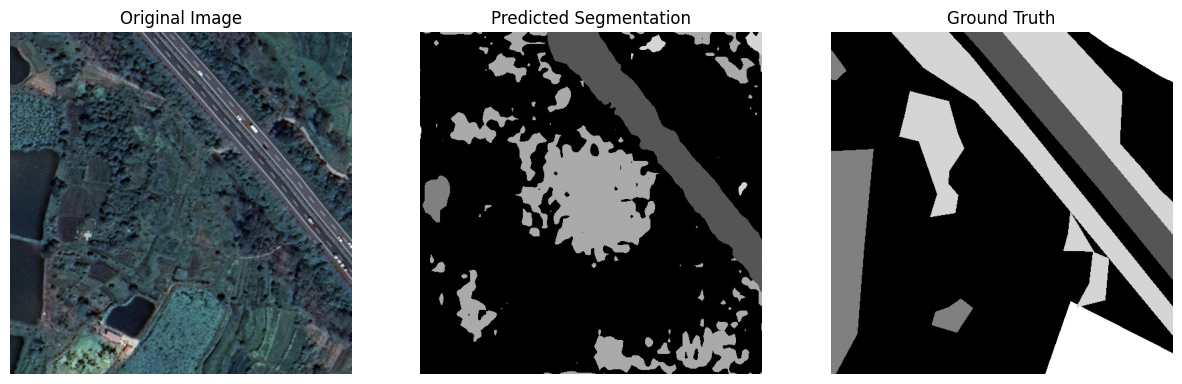

Params: 7.718 M


In [56]:
"""
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
"""